In [2]:
%matplotlib inline

In [5]:
import pandas as pd

# The files are coded in ISO-8859-1

df = pd.read_csv("data/Emocion-No.csv")
df[:5]

,Tweet,Info,Info2
0,@AS_Manolete Y con el atleti podemos soñar otr...,Emocion,Cólera
1,Jugando asi es imposible que ganemos un partido…,Emocion,Tristeza
2,@eSports_Barca @MNDZPAU1 Md,NoEmocion,NoEmocion
3,Ahhhh claro que es del Atleti https://t.co/xm4...,NoEmocion,NoEmocion
4,Que venga Arthur me tiene más emocionado que c...,Emocion,Felicidad


In [6]:
df.shape

(763, 3)

In [7]:
# Define X and Y
X = df['Tweet'].values.astype(str)
y = df['Info'].values.astype(str)

In [8]:
# Transformer 1


# Sample of statistics using nltk
# Another option is defining a function and pass it as a parameter to FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import sent_tokenize, word_tokenize

class LexicalStats (BaseEstimator, TransformerMixin):
    """Extract lexical features from each document"""
    
    def number_sentences(self, doc):
        sentences = sent_tokenize(doc, language='english')
        return len(sentences)

    def fit(self, x, y=None):
        return self

    def transform(self, docs):
        return [{'length': len(doc),
                 'num_sentences': self.number_sentences(doc)}
                for doc in docs]

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string


def custom_tokenizer(words):
    
    
    """Preprocessing tokens as seen in the lexical notebook"""
    tokens = word_tokenize(words.lower())
    porter = PorterStemmer()
    lemmas = [porter.stem(t) for t in tokens]
    stoplist = stopwords.words('english')
    lemmas_clean = [w for w in lemmas if w not in stoplist]
    punctuation = set(string.punctuation)
    lemmas_punct = [w for w in lemmas_clean if  w not in punctuation]

    
    return lemmas_punct


In [10]:
from simM import SimMatrix
from gensim.models import KeyedVectors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
from gsitk.preprocess import normalize
import numpy as np
import pandas as pd

class Transformador (BaseEstimator, TransformerMixin):
    def fit (self, x, y=None):
        return self
    def transform(self, X):
        array = []
        for i in range(0,len(X)):
            array.append(normalize.preprocess(X[i]))
        return np.array(array)

In [11]:
embeddings = KeyedVectors.load_word2vec_format('./SBW-vectors-300-min5.txt')

In [12]:
lexicon = pd.read_csv('ElhPolar_esV1.lex.txt', sep='\t', header=None, names=['word', 'sentiment'])
positive = list(set(lexicon[lexicon['sentiment']=='positive']['word'].values))
negative = list(set(lexicon[lexicon['sentiment']=='negative']['word'].values))
lexicon_words = [positive,negative]

In [14]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer


ngrams_featurizer = Pipeline([
  ('count_vectorizer',  CountVectorizer(analyzer="word", max_df=0.5, ngram_range=[1,2])),
  ('tfidf_transformer', TfidfTransformer())
])


from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation




from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier #For Classification
from sklearn.neighbors import KNeighborsClassifier

## All the steps of the Pipeline should end with a sparse vector as the input data

pipeline = Pipeline([
       ('features', FeatureUnion([
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),

                   ('ngrams', ngrams_featurizer),
                   ('lexical_stats', Pipeline([
                                        ('stats', LexicalStats()),
                                        ('vectors', DictVectorizer())
                                    ])),
                   ('lda', Pipeline([ 
                            ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                            ('lda',  LatentDirichletAllocation(n_topics=4, max_iter=5,
                                                   learning_method='online', 
                                                   learning_offset=50.,
                                                   random_state=0))
                        ])),
                    ('emb', Pipeline([
                            ('preprocess', Transformador()),
                            ('simM', SimMatrix(lexicon_words, embedding=embeddings,
                                               remove_stopwords=False, pooling=np.max,
                                               weighting=False, n_lexicon_words=100,
                                               lex_values=None)),
                            ('scale', MinMaxScaler(feature_range=(0,1))),
                            ('percent', feature_selection.SelectPercentile(feature_selection.f_classif, percentile=25)),
                        ]))

              ])),
       

                #('clf', MultinomialNB(alpha=.01))  # classifier
            ('clf', SVC(C=10, gamma= 1, kernel='linear', probability=True))
        #('clf', AdaBoostClassifier(n_estimators=10, base_estimator=MultinomialNB(alpha=.01), learning_rate=1))
        #('modelknn', KNeighborsClassifier(n_neighbors = 13))
    ])
#SVC, KNeighborsClassifier, AdaBoostClassifier, MultinomialNB
# Using KFold validation

cv = KFold(X.shape[0], 4, shuffle=True, random_state=33)
scores = cross_val_score(pipeline, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [ 0.71204188  0.70680628  0.7434555   0.66315789]
Accuracy: 0.71 (+/- 0.06)


In [77]:
pipeline.fit(X,y)

#y=pipeline.predict(['Vaya partido mas aburrido'])
#print(y)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('words', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_r...   transformer_weights=None)), ('clf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])

In [50]:
'ganar' in lexicon_words[0]

True

In [78]:
l = pipeline.named_steps['features'].transformer_list[4][1].named_steps['simM'].lex_words

In [79]:
len(l)

200

In [80]:
len(set(l))

200

In [88]:
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
from simM import SimMatrix
import matplotlib.pyplot as plt

def plot_selected_feats(pipe, data_name, all_feats):
    feats = sorted(zip(pipe.named_steps['features'].transformer_list[4][1].named_steps['simM'].lex_words,
                       pipe.named_steps['features'].transformer_list[4][1].named_steps['percent'].scores_),
                   key=lambda x: x[1], reverse=True)
    all_feats[data_name] = feats

    plt.plot(range(len(feats)), [f[1] for f in feats], 'o')
    plt.title(data_name)
    plt.show()

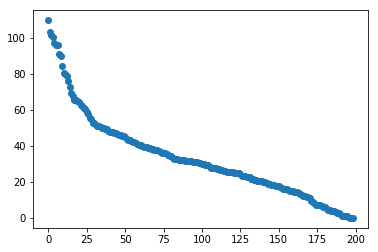

In [89]:
features = dict()
plot_selected_feats(pipeline, '', features)

In [ ]:
import seaborn as sns


In [86]:
features['']

[('mediocre', 109.58501),
 ('lesionado', 103.33264),
 ('despilfarro', 101.51237),
 ('mal', 100.0899),
 ('gastar', 96.983696),
 ('peor', 95.914711),
 ('atrás', 95.853142),
 ('fanático', 90.626419),
 ('sólo', 89.557091),
 ('soberbia', 84.250191),
 ('difícil', 80.305305),
 ('falso', 79.934502),
 ('rata', 78.837578),
 ('pobre', 75.872833),
 ('malo', 72.737839),
 ('extraño', 69.02932),
 ('jesús', 67.46534),
 ('envidia', 65.502327),
 ('gastado', 65.448532),
 ('jajajaja', 64.776398),
 ('problema', 64.327759),
 ('paleto', 62.447891),
 ('contrario', 62.186558),
 ('atacar', 60.972458),
 ('pasada', 60.137627),
 ('bien', 58.828526),
 ('cierto', 57.598907),
 ('verdad', 55.596001),
 ('quiero', 54.871967),
 ('frío', 52.538376),
 ('fracaso', 52.435741),
 ('bueno', 51.577042),
 ('feliz', 51.147247),
 ('cagarse', 51.075954),
 ('quitar', 50.592358),
 ('sueños', 49.937393),
 ('mierda', 49.83379),
 ('no', 49.456181),
 ('seguro', 49.210258),
 ('excepción', 48.437943),
 ('eres', 47.638393),
 ('gilipollas', 4